In [1]:
from dotenv import load_dotenv
import os

load_dotenv('../.env')

True

In [2]:
from langchain_ollama import ChatOllama

# model = "llama3.2:3b"
model = "qwen2.5"
llm = ChatOllama(model=model, base_url="http://localhost:11434")
print(llm.invoke("Hello, how are you?"))

content="Hello! I'm just a computer program, so I don't have feelings or physical sensations, but I'm here and ready to help you with any questions or conversations you'd like to have. How can I assist you today?" additional_kwargs={} response_metadata={'model': 'qwen2.5', 'created_at': '2024-11-30T07:14:51.8464671Z', 'message': {'role': 'assistant', 'content': ''}, 'done_reason': 'stop', 'done': True, 'total_duration': 15627695900, 'load_duration': 5668573400, 'prompt_eval_count': 35, 'prompt_eval_duration': 522479000, 'eval_count': 47, 'eval_duration': 9432399000} id='run-0d4da219-77ed-42e2-826d-943ba56bd57f-0' usage_metadata={'input_tokens': 35, 'output_tokens': 47, 'total_tokens': 82}


In [3]:
# import requests

# url = "https://storage.googleapis.com/benchmarks-artifacts/chinook/Chinook.db"

# response = requests.get(url)

# if response.status_code == 200:
#     # Open a local file in binary write mode
#     with open("Chinook.db", "wb") as file:
#         # Write the content of the response (the file) to the local file
#         file.write(response.content)
#     print("File downloaded and saved as Chinook.db")
# else:
#     print(f"Failed to download the file. Status code: {response.status_code}")



from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///Chinook.db")
print(db.dialect)
print(db.get_usable_table_names())
db.run("SELECT * FROM Artist LIMIT 10;")

sqlite
['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']


"[(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains'), (6, 'Antônio Carlos Jobim'), (7, 'Apocalyptica'), (8, 'Audioslave'), (9, 'BackBeat'), (10, 'Billy Cobham')]"

In [4]:
# Application state
from typing import TypedDict


class State(TypedDict):
    question: str
    query: str
    result: str
    answer: str


# Convert question to SQL query
# We will pull a prompt from the Prompt Hub to instruct the model.
from langchain import hub

query_prompt_template = hub.pull("langchain-ai/sql-query-system-prompt")

# assert len(query_prompt_template.messages) == 1
query_prompt_template.messages[0].pretty_print()

# query_prompt_template



================================ System Message ================================

Given an input question, create a syntactically correct {dialect} query to run to help find the answer. Unless the user specifies in his question a specific number of examples they wish to obtain, always limit your query to at most {top_k} results. You can order the results by a relevant column to return the most interesting examples in the database.

Never query for all the columns from a specific table, only ask for a the few relevant columns given the question.

Pay attention to use only the column names that you can see in the schema description. Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table.

Only use the following tables:
{table_info}

Question: {input}


In [5]:
from typing import Annotated


class QueryOutput(TypedDict):
    """Generated SQL query."""

    query: Annotated[str, ..., "Syntactically valid SQL query."]


def write_query(state: State):
    """Generate SQL query to fetch information."""
    prompt = query_prompt_template.invoke(
        {
            "dialect": db.dialect,
            "top_k": 10,
            "table_info": db.get_table_info(),
            "input": state["question"],
        }
    )
    structured_llm = llm.with_structured_output(QueryOutput)
    result = structured_llm.invoke(prompt)
    print("Result", result)
    return {"query": result["query"]}


# query output metadata
QueryOutput.__annotations__

{'query': typing.Annotated[str, Ellipsis, 'Syntactically valid SQL query.']}

In [6]:
llm.with_structured_output(QueryOutput)

write_query({"question": "How many Employees are there?"})

Result {'query': 'SELECT COUNT(*) FROM Employee'}


{'query': 'SELECT COUNT(*) FROM Employee'}

In [7]:
# Execute query
from langchain_community.tools.sql_database.tool import QuerySQLDataBaseTool


def execute_query(state: State):
    """Execute SQL query."""
    execute_query_tool = QuerySQLDataBaseTool(db=db)
    return {"result": execute_query_tool.invoke(state["query"])}

execute_query({'query': 'SELECT COUNT(*) FROM Employee'})

{'result': '[(8,)]'}

In [ ]:
# Generate answer
# Finally, our last step generates an answer to the question 
# given the information pulled from the database:

def generate_answer(state: State):
    """Answer question using retrieved information as context."""
    prompt = (
        "Given the following user question, corresponding SQL query, "
        "and SQL result, answer the user question.\n\n"
        f'Question: {state["question"]}\n'
        f'SQL Query: {state["query"]}\n'
        f'SQL Result: {state["result"]}'
    )
    response = llm.invoke(prompt)
    return {"answer": response.content}


question = "How many Employees are there?"
query = write_query({"question": question})
result = execute_query(query)



In [14]:
state = {"question": question, **query, **result}
print(state)

generate_answer(state)

{'question': 'How many Employees are there?', 'query': 'SELECT COUNT(*) FROM Employee', 'result': '[(8,)]'}


{'answer': "Based on the SQL result provided, the number of employees is 8. Therefore, to directly answer the user's question:\n\nThere are 8 employees."}

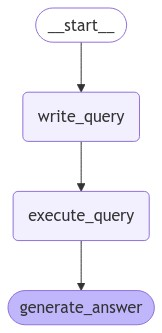

In [16]:
# Orchestrating with LangGraph
# Finally, we compile our application into a single graph object.
# In this case, we are just connecting the three steps into a single sequence.

from langgraph.graph import START, StateGraph
from IPython.display import Image, display

graph_builder = StateGraph(State)

graph_builder.add_node("write_query", write_query)
graph_builder.add_node("execute_query", execute_query)
graph_builder.add_node("generate_answer", generate_answer)

graph_builder.add_edge(START, "write_query")
graph_builder.add_edge("write_query", "execute_query")
graph_builder.add_edge("execute_query", "generate_answer")


graph = graph_builder.compile()


display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
query = {"question": "How many employees are there?"}

for step in graph.stream(query, stream_mode="updates"):
    print(step)

Result {'query': 'SELECT COUNT(*) FROM Employee'}
{'write_query': {'query': 'SELECT COUNT(*) FROM Employee'}}
{'execute_query': {'result': '[(8,)]'}}
{'generate_answer': {'answer': "Based on the SQL result provided, the number of employees is 8. Therefore, to directly answer the user's question: There are 8 employees."}}


### AGENTS

- They can query the database as many times as needed to answer the user question.
- They can recover from errors by running a generated query, catching the traceback and regenerating it correctly.
- They can answer questions based on the databases' schema as well as on the databases' content (like describing a specific table).

In [18]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit

toolkit = SQLDatabaseToolkit(db=db, llm=llm)

tools = toolkit.get_tools()

tools

[QuerySQLDataBaseTool(description="Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.", db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x000001BE74298E60>),
 InfoSQLDatabaseTool(description='Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3', db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x000001BE74298E60>),
 ListSQLDatabaseTool(db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x000001BE74298E60>),
 QuerySQLCheckerTool(description='Use this tool to 

In [19]:
from langchain import hub

prompt_template = hub.pull("langchain-ai/sql-agent-system-prompt")

assert len(prompt_template.messages) == 1
prompt_template.messages[0].pretty_print()

================================ System Message ================================

You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct {dialect} query to run, then look at the results of the query and return the answer.
Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most {top_k} results.
You can order the results by a relevant column to return the most interesting examples in the database.
Never query for all the columns from a specific table, only ask for the relevant columns given the question.
You have access to tools for interacting with the database.
Only use the below tools. Only use the information returned by the below tools to construct your final answer.
You MUST double check your query before executing it. If you get an error while executing a query, rewrite the query and try again.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to th

In [ ]:
system_message = prompt_template.format(dialect="SQLite", top_k=5)

In [ ]:
# Initializing agent
# We will use a prebuilt LangGraph agent to build our agent

from langchain_core.messages import HumanMessage
from langgraph.prebuilt import create_react_agent

agent_executor = create_react_agent(llm,
                                    tools,
                                    state_modifier=system_message)

display(Image(agent_executor.get_graph().draw_mermaid_png()))

================================ Human Message =================================

Which country's customers spent the most?
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (1b32034a-0d03-4fac-8ae8-80bbfd588093)
 Call ID: 1b32034a-0d03-4fac-8ae8-80bbfd588093
  Args:
================================= Tool Message =================================
Name: sql_db_list_tables

Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (34e50b56-b6ea-489b-873c-fb45c10fb32d)
 Call ID: 34e50b56-b6ea-489b-873c-fb45c10fb32d
  Args:
    table_names: Invoice,Customer
================================= Tool Message =================================
Name: sql_db_schema


CREATE TABLE "Customer" (
	"CustomerId" INTEGER NOT NULL, 
	"FirstName" NVARCHAR(40) NOT NULL, 
	"LastName" NVARCHA

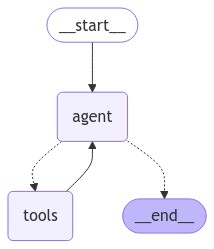

In [ ]:
question = "Which country's customers spent the most?"
query = {"messages": [HumanMessage(question)]}
for step in agent_executor.stream(query, stream_mode="values"):
    step["messages"][-1].pretty_print()